<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Install useful libraries

In [47]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [48]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [49]:
# Start coding here
# Use as many cells as you need.
import os
openai_api_key = os.getenv("OPENAI_API_KEY")

In [50]:
# Start coding here
# Use as many cells as you need.
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import chromadb
from scipy.spatial import distance
import openai

In [51]:
review_texts = reviews["Review Text"].dropna()

In [52]:
client = openai.OpenAI(api_key=openai_api_key)
responses = client.embeddings.create(
		model="text-embedding-3-small",
		input=review_texts
		).model_dump()

In [53]:
embeddings = [response['embedding'] for response in responses['data']]

In [54]:
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
embeddings_2d = tsne.fit_transform(np.array(embeddings))

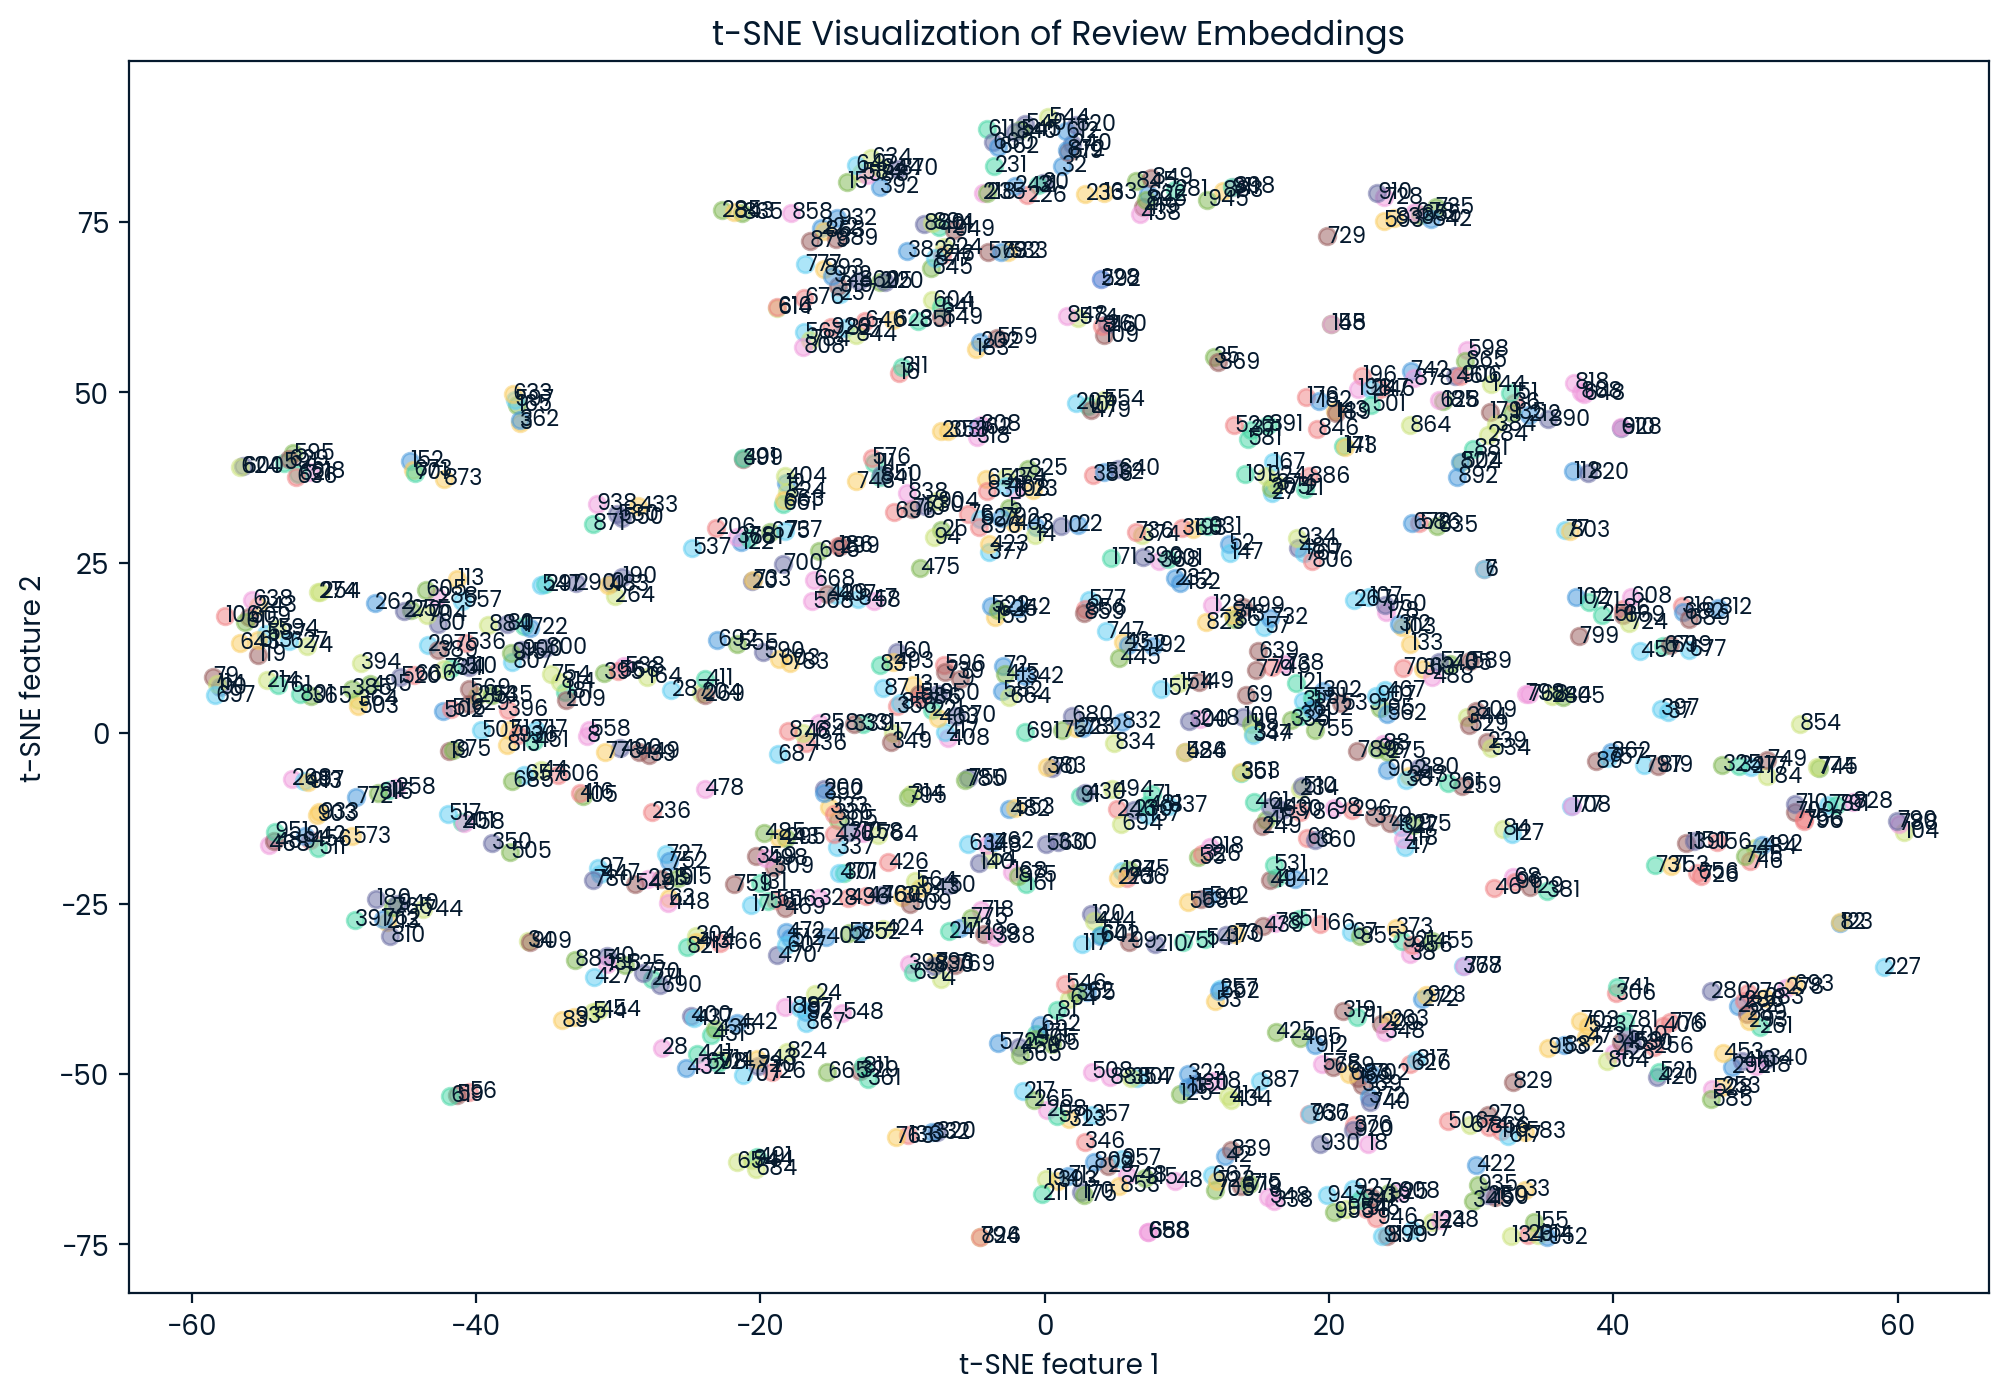

In [55]:
def plot_tsne(tsne_results):
    plt.figure(figsize=(12, 8))
    for i, point in enumerate(tsne_results):
        plt.scatter(point[0], point[1], alpha=0.5)
        plt.text(point[0], point[1], str(i), fontsize=8, verticalalignment='center')
    plt.title("t-SNE Visualization of Review Embeddings")
    plt.xlabel("t-SNE feature 1")
    plt.ylabel("t-SNE feature 2")
    plt.show()

plot_tsne(embeddings_2d)

In [56]:
categories = ["Quality", "Fit", "Style", "Comfort"]

In [57]:
category_responses = client.embeddings.create(
    input=categories,
    model="text-embedding-3-small"
).model_dump()

category_embeddings = [embedding["embedding"] for embedding in category_responses["data"]]

In [58]:
# Function to categorize feedback
def categorize_feedback(text_embedding, category_embeddings):
    similarities = [{"distance": distance.cosine(text_embedding, cat_emb), "index":i}
                     for i, cat_emb in enumerate(category_embeddings)]
    closest = min(similarities, key=lambda x: x["index"])
    return categories[closest["index"]]

# Categorize feedback
feedback_categories = [categorize_feedback(embedding, category_embeddings) for embedding in embeddings]

In [59]:
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

client = chromadb.PersistentClient()

try:
    review_embeddings_db = client.create_collection(
        name="review_embeddings",
        embedding_function=OpenAIEmbeddingFunction(model_name="text-embedding-3-small",
                                                   api_key=openai_api_key)
    )
    review_embeddings_db.add(
        documents=review_texts.tolist(),
        ids=[str(i) for i in range(len(review_texts))]
    )
except Exception as e:
    print(f"Error creating collection: {e}")

def find_similar_reviews(input_text, vector_db, n=3):
    try:
        collection = client.get_collection(
            name="review_embeddings",
            embedding_function=OpenAIEmbeddingFunction(model_name="text-embedding-3-small",
                                                       api_key=openai_api_key)
        )
        results = collection.query(
            query_texts=[input_text],
            n_results=n
        )
        return results
    except Exception as e:
        print(f"Error retrieving collection or querying: {e}")
        return None

Error creating collection: Collection review_embeddings already exists


In [60]:
# Example feedback and finding similar feedback
example_review = "Absolutely wonderful - silky and sexy and comfortable"
most_similar_reviews = find_similar_reviews(example_review, review_embeddings_db, 3)["documents"][0]
print(most_similar_reviews)

['Absolutely wonderful - silky and sexy and comfortable', 'Very comfortable and versatile. got lots of compliments.', 'This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.']
